# BUSINESS PROBLEM

We are creating a deep learning model that can forecast the probability of breast cancer by analyzing many features obtained from cell nuclei found in samples of breast tissue. This model's main goal is to support medical practitioners in early diagnosis and identification, allowing for prompt intervention and better patient outcomes. The model attempts to efficiently differentiate between benign and malignant tumors by utilizing variables including mean fractional dimension, mean symmetry, mean concavity, mean concave points, mean smoothness, mean compactness, mean radius, mean texture, mean perimeter, and mean area. This will ultimately help with better management of breast cancer by facilitation tailored treatment plans, focused therapies, and educated decision-making in clinical settings.

# IMPORTING MODULES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# DATA COLLECTION

In [2]:
cancer_data= load_breast_cancer()
dataframe = pd.DataFrame(cancer_data.data, columns= cancer_data.feature_names)
df = dataframe.copy()
df['label'] = cancer_data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# DATA EXPLORATION


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
label                      0
dtype: int64

In [6]:
df['label'].value_counts()

label
1    357
0    212
Name: count, dtype: int64

1 ---> Malignant
0 ---> Not Malignant

Since the dataset is not balanced so there is a higher chance of my model to perform towards one side so in later stages I will be performing balancing of dataset using oversampling technique(SMOTE).

# DATA PREPROCESSING


In [7]:
x = df.drop(columns= 'label', axis=1)
y = df['label']
smote_sampler = SMOTE(random_state=42)
X_resamples, Y_resamples = smote_sampler.fit_resample(x, y)

Here we split the columns based upon dependent and independent variables.
1. **x:** It contains feature set without the label column here.

2. **y:** It contains only target labels only.

Since the target label is not balanced as I mentioned earlier step in the piple here I'm doing **smote** over sampling in order to balance the dataset and work effectively by creating initializing **SMOTE** object with random sampling size to **42**. We are creating the two new variables here **X_resamples** and **Y_resamples** in order to fit the resampled datapoints.

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(X_resamples, Y_resamples, test_size=0.3, random_state=42, stratify=Y_resamples)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Since we are going to develop deep learning model and traditional model so we are spliting the dataset into different part **x_train**, **x_temp**, **x_val**, **x_test**, **y_train**, **y_temp**, **y_val**, **y_test**. Here we use x & y train & temp we use it for traditional method and x & y val and test we use it for deep learning model. For model to show perform well in deep learning model and show the comparision between them. 

# FEATURE ENGINEERING

In [9]:
scaler_obj = StandardScaler()
x_train = scaler_obj.fit_transform(x_train)
x_val = scaler_obj.transform(x_val)
x_test = scaler_obj.transform(x_test)

In Feature Engineering we standardizing the data. By Doing **StandardScaler** it will **improves convergence** of the dataset. It ensure that all the data (training, validation and test) are on the same scale which is known as **Consistency**.

1.we create a **scaler_obj** object for initializes the **StandardScaler**.

2.The training dataset (**x_train**) is transformed using the **fit_transform** technique.

3.**transforms** method is performed on the validation dataset (**x_val**) it transform the validation data by using the training data statistics.

4.The test dataset (**x_test**) is transformed using the training data statistics by applying the same **transforms** procedure.

# BUILDING THE MODEL 

## TRADITIONAL METHOD


In [10]:
svm_parameters = {'C' : [0.1,1,10,100,1000], 'kernel' : ['rbf'], 'gamma' : ['scale','auto']}
grid_search_svm = GridSearchCV(SVC(), svm_parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_svm.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
             verbose=1)

In [11]:
best_params = grid_search_svm.best_params_
best_score = grid_search_svm.best_score_
print("The SVM best parameters are:", best_params)
print("Best Cross_Validation Score: {:.2f}".format(best_score))

The SVM best parameters are: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross_Validation Score: 0.98


## DEEP LEARNING MODEL


In [12]:
model = Sequential(
    [
        Flatten(input_shape=(30,)),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 128)               3968      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

1. **Sequential Model:** The model layers are stacked sequentially.

2. **Layers:**

     a.**Flatten Layer:** It creates a 30-element **1D** array  from the supplied shape..

     b.**Dense Layer:** Fully connencted layer with 128 neuros, resulting in 3968 trainable parameters(free parameters).

     c.**LeakyReLU:** It is used to address the problem of dying ReLu by adding non-zero gradient when the input is negative.

     d.**BatchNormalization:** It improves the training dataset by normalizing the inputs to each layer.

     e.**Dropout layer:** Applies dropout to prevent overfitting (No parameters).

     f.**Dense layer:** Fully connected layer with 10 neurons (Output Layer), resulting in 1290 trainable parameters.

4. **Total Parameters:** 5514 all of which are trainable.There are 256 non-trainable parameters.

In [18]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint('best_breast_cancer_model.keras', save_best_only=True)
history = model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val),
                   callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/25
16/16 [==============================] - 2s 28ms/step - loss: 0.0697 - accuracy: 0.9739 - val_loss: 0.0775 - val_accuracy: 0.9720
Epoch 2/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0538 - accuracy: 0.9820 - val_loss: 0.0791 - val_accuracy: 0.9720
Epoch 3/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0278 - accuracy: 0.9880 - val_loss: 0.0760 - val_accuracy: 0.9720
Epoch 4/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.9739 - val_loss: 0.0849 - val_accuracy: 0.9720
Epoch 5/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0560 - accuracy: 0.9820 - val_loss: 0.0863 - val_accuracy: 0.9720
Epoch 6/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0439 - accuracy: 0.9860 - val_loss: 0.0777 - val_accuracy: 0.9720


1. **Model Compliation:**

   a.**Optimizer:** adam(Adaptive Moment Estimation), which is an efficient and popular optimization.

   b.**Loss Function:** SpareCategoricalCrossentropy with **from_logits** = **True**, used for multi-class classification problems where the target                             variable is in integer form.

   c. **Metrics:** Accuracy, to monitor the accuracy of the model during training and evaluation.

2. **EarlyStopping:** If the training does not improve after three consecutive epochs (**patience=3**), it terminates. It does this by monitoring the validation loss (**val_loss**). Additionally, it sets **restore_best_weights=True**, which returns the model weights from the epoch with the lowest validation loss.

3. **Model Checkpoint:** saves the model to the file '**best_breast_cancer_model.keras**' only when the validation loss imporves (**save_best_only = True**).

4. **Model Training:**

   a.**Data:** Trains on x_train and y_train and validates on x_val and y_val.
   
   b.**Epochs:** Trains for a maximum of 30 epochs.

   c.**Callbacks:** Uses **early_stopping** and **model_checkpoint** during training to control early stopping and model saving.

5. **History:** The training process history, comprising loss and accuracy metrics for the training and validation sets over the epochs, is stored in the history variable.

# EVALUATION 

In [19]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.9815
Test Loss: 0.06726759672164917
Test Accuracy: 0.9814814925193787


# EXPERIMENTS

Some of the experiments are conducted in order to tell that my above deep learning model piple is the best one for the above dataset which is **breast_cancer_dataset**

## EXP 1 ##

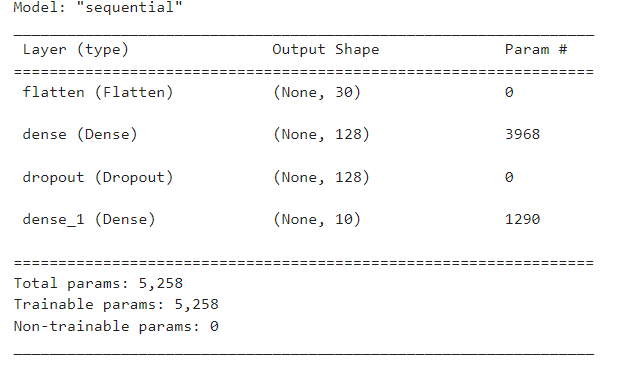

## EXP 2 ##

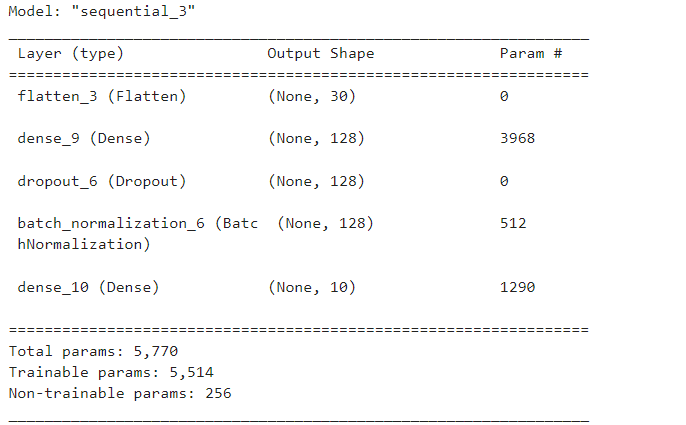

In the second model pipeline I just include **batch_normalization layer** in the sequential of layers. By doing this number of **free parameter** by batch normalization is **512** and their is slight changes see in **total params** to **5770** and **trainable params** to **5514** and **non_trainable params** is **256**. By doing this **x_val** is dropped **0.9136** 

## EXP 3 ##

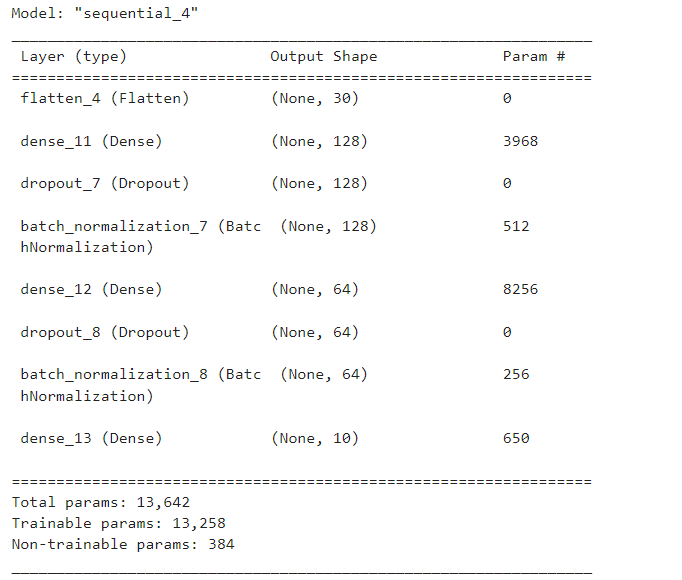

Here I change the **activation** function of the first **dense** layer to **tanh** and added another **dense** layer with same **tanh** activation function. By doing this I got the **x_val** score is **0.9359**

## EXP 4 ##

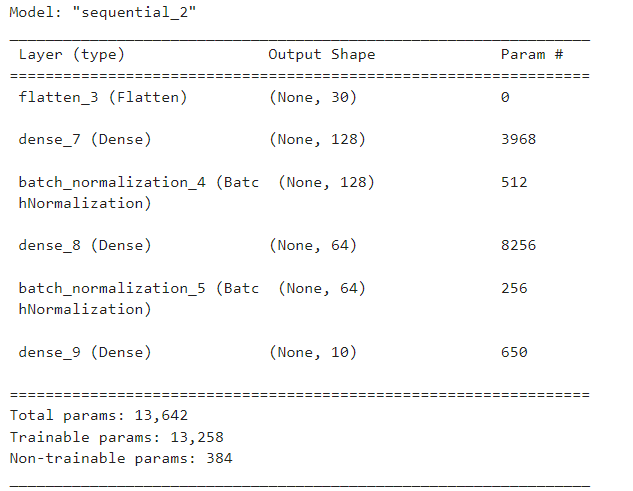

In the forth model pipeline I just exclude **dropout** in the sequential of layers. By doing this number of **free parameter** by batch normalization is **512** and their is slight changes see in **total params** to **13642** and **trainable params** to **13258** and **non_trainable params** is **384**. By doing this **x_val** is dropped **0.9053** 

## EXP 5 ##

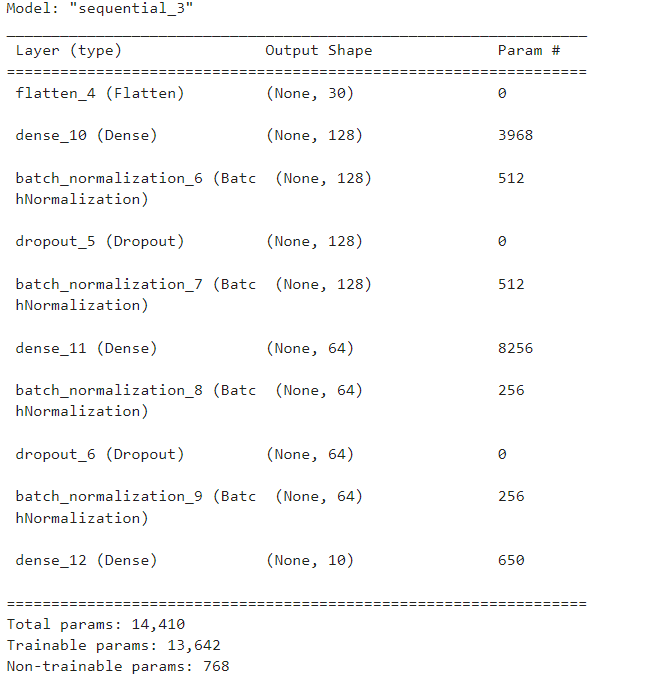

Here I added extra **2** **BatchNormalization** layer in between the **sequential** model adding up to the already existing **2** **BatchNormalization** in total in this pipeline we have **4** batchnormalization. By doing this I got the **x_val** score is **0.8801**

## EXP 6 ##

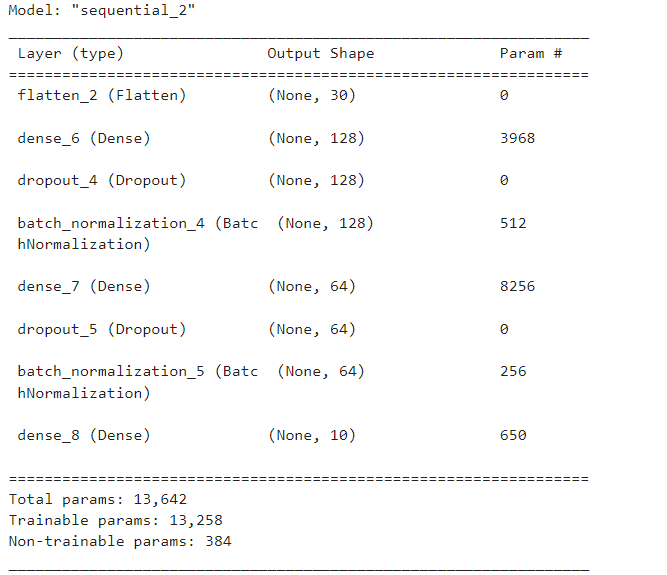

Here in the last layer **Dense** I change the **activation** function to **sigmoid**. By doing this the **x_val** score is **0.9081**

## EXP 7 ##

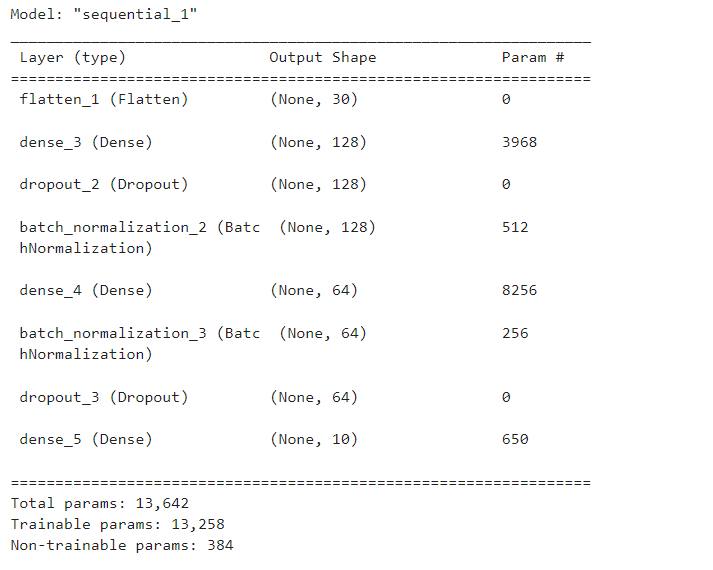

Here I just moved **dropout** layer after **batchnormalization** rest remains the same there is no change in the total params, trainable params and non-trainable params. But the **x_val** score is decreased to **0.8997** 

## EXP 8 ##

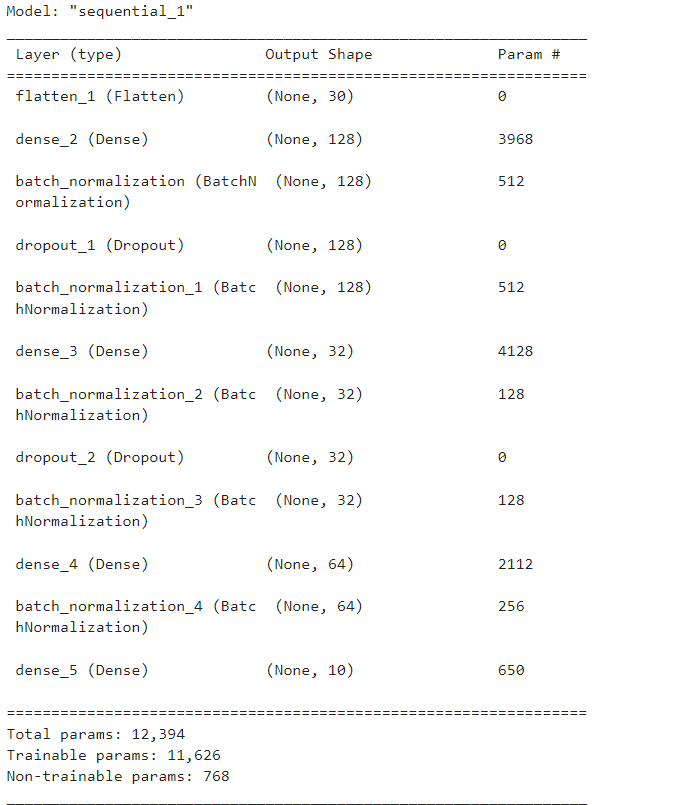

Here I include one more **dense** layer in between **batchnormalization** layer with the **activation** function kept as **softmax**. by doing this the **x_val** score is **0.9252**

## EXP 9 ##

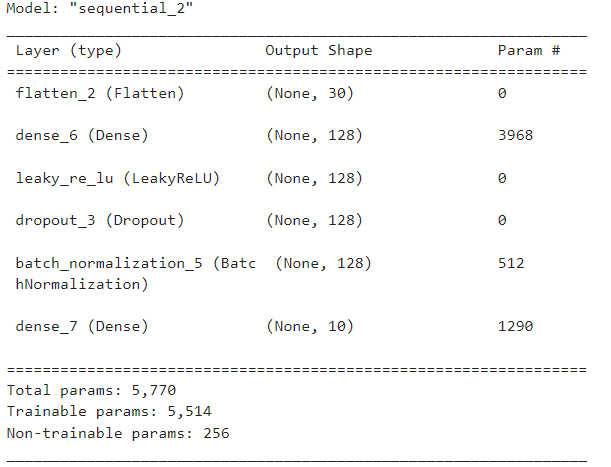

By adding **LeakyRelu** in the pipeline with **alpha** = **0.1**. The **x_val** score got increased to **0.9720**

## EXP 10 ##

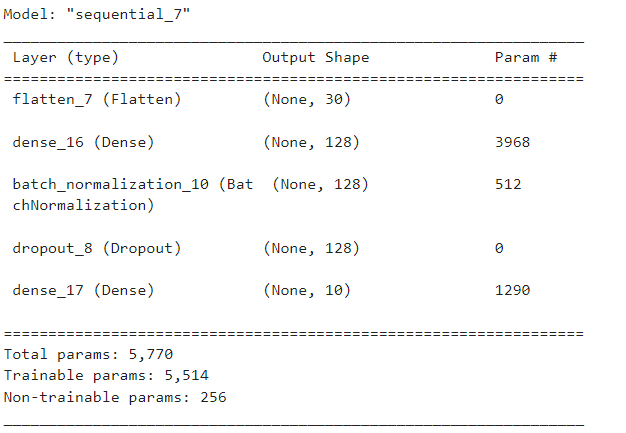

Here I introduce **L2 regularization** with **0.01** set value in the **dense** layer. by doing this **x_val** score is **0.9533**

## KEY FINDINGS

1. **Impact of Neuron Count** : As we included number of nuerons to the sequential pipeline it help the model to learn better but unfortunately the                                     model is prone to overfitting.

2. **Regularization** : Both the dropout and L2 regularization helped in reducing overfiting problem since I kept dropout rate to **0.5**.

3. **BatchNormalization** : It improves the model's convergence and performance. Though my dataset is simple I didn't have batchnormalization on my final model.

4. **Activation Functions** : I keep exprimenting my model pipeline with **sigmoid** or **tanh** function on different model. Inorder to provide how activation function affect the learning dynamics. Though **ReLU** was effective.

5. **Model Complexity** : It places vital role by adding more layers and neurons which increased the model complexity and its capacity to learn from data.

6. **Layer Positioning** : The positioning of the **dropout** and **batchnormalization** layers influenced the model's performance and I have witnessed it my **x_val** score.

# CONCLUSION 

The neural network project, which used TensorFlow and Keras, effectively proved the potential of deep learning algorithms in machine learning. Through careful feature engineering, data analysis, and model tuning, I was able to create a prediciting tool that works well and has a high classification accuracy. My tests showed that in order to get optimal performance, it is essential to find a balance between model complexity and appropriate regularization.The predicitive models that are developed can be tailored to function with certain datasets and tasks, enhancing their accuracy and reliability in a range of scenarios. This work lays a solid foundation for future advancements in predictive modeling by highlighting the revolutionary potential of machine learning in solving real-world problems and furthering progress in various disciplines.

# DATASET SOURCE LINK

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html